In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dropout
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from PIL import Image
import pandas as pd
import numpy as np
import statistics
import shutil
import cv2
import os


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
# Define the path to the 'train_Images_Source_2' folder
folder_path = r"D:\Projects\Weed Detection\Processed data\train"

# List all folders in the directory
folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

# Print the names of the folders
for folder_name in folders:
    print(folder_name)


Common wheat
Convolvulus arvensis
Cotton
Euphorbia peplus
Grass
Lolium multiflorum
Maize
Nutgrass
Purslane
Sesame
Sugar beet
Tomato


In [18]:
def is_image_white(img_path):
    """
    Check if the image is completely white.
    """
    try:
        with Image.open(img_path) as img:
            # Convert image to a format that supports checking pixel values directly
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Get all pixel data from the image
            pixels = img.getdata()
            # Check if all pixels are white (255, 255, 255 in RGB)
            return all(pixel == (255, 255, 255) for pixel in pixels)
    except IOError:
        # If the file isn't an image, this will skip it
        return False

def delete_white_images(directory):
    """
    Delete all completely white images in the specified directory, including subdirectories.
    Count and print the number of deleted images.
    """
    # List of common image file extensions to check
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.ico', '.webp','.tif','JPG')
    deleted_count = 0  # Initialize a counter for deleted images
    
    for foldername, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(image_extensions):
                file_path = os.path.join(foldername, filename)
                try:
                    if is_image_white(file_path):
                        os.remove(file_path)
                        deleted_count += 1  # Increment the counter upon successful deletion
                        print(f"Deleted white image: {file_path}")
                except Exception as e:
                    print(f"Failed to process or delete {file_path}. Reason: {e}")

    # Print the total number of deleted images
    print(f"Total white images deleted: {deleted_count}")

# Replace 'path_to_your_main_folder' with the path to your main folder containing subfolders with images.
main_directory = "D:\Projects\Weed Detection\Processed data"
delete_white_images(main_directory)


Total white images deleted: 0


In [5]:
import os
import cv2
import numpy as np

def find_colored_pixels(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Find the first and last non-white pixel
    first_colored_pixel = np.where(gray != 255)
    last_colored_pixel = (np.max(first_colored_pixel[0]), np.max(first_colored_pixel[1]))

    # Find the top-left and bottom-right coordinates of the colored region
    top_left = (np.min(first_colored_pixel[1]), np.min(first_colored_pixel[0]))
    bottom_right = (last_colored_pixel[1], last_colored_pixel[0])

    return top_left, bottom_right

def crop_image(image, top_left, bottom_right):
    cropped_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    return cropped_image

def process_images_in_directory(directory):
    # Loop through all files and subdirectories in the given directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is an image file
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp','.gif', '.tiff', '.ico', '.webp','.tif','JPG')):
                # Load the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Find the coordinates of the first and last colored pixel
                top_left, bottom_right = find_colored_pixels(image)

                # Crop the image
                cropped_image = crop_image(image, top_left, bottom_right)

                # Save the cropped image as PNG with the same name as the original image (overwrite the original)
                cv2.imwrite(image_path, cropped_image, [cv2.IMWRITE_PNG_COMPRESSION, 0])  # Set PNG compression to 0 for lossless

def main():
    # Specify the directory containing the images
    directory = r"D:\Projects\Weed Detection\Processed data\train\Tomato"
    
    # Process all images in the directory and its subdirectories
    process_images_in_directory(directory)

if __name__ == "__main__":
    main()


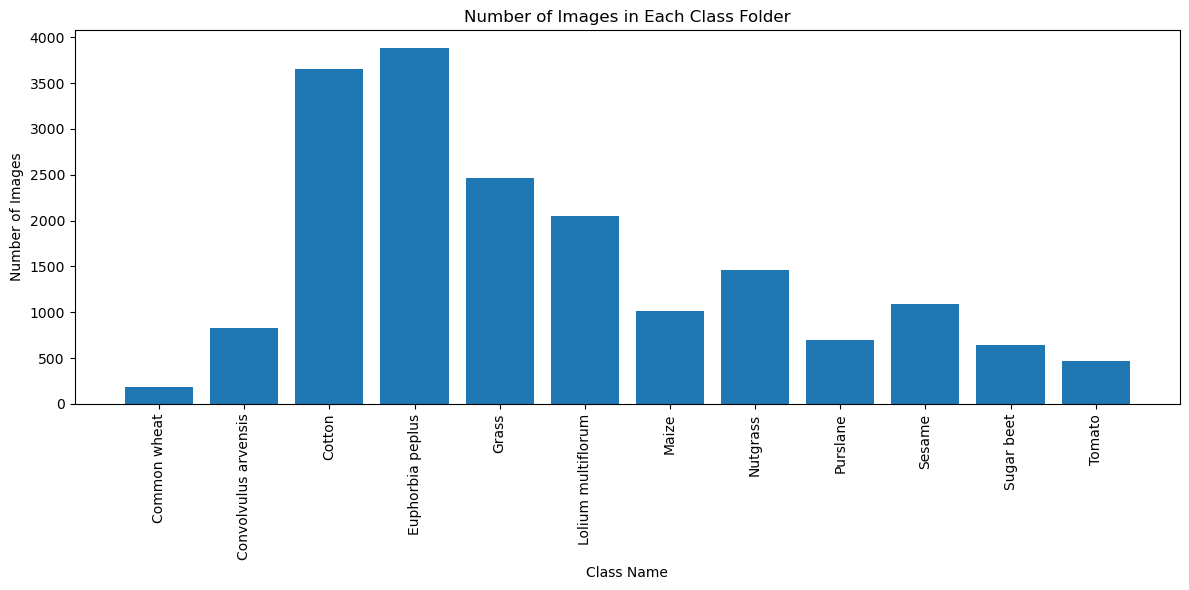

In [6]:
# Get a list of all class folders in the 'merged_folder'
class_folders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Initialize lists to store class names and corresponding image counts
class_names = []
image_counts = []

# Iterate through each class folder and count the images
for class_folder in class_folders:
    class_path = os.path.join(folder_path, class_folder)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_names.append(class_folder)
        image_counts.append(image_count)

# Create a bar chart to visualize the image counts for each class
plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts)
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class Folder')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the bar chart
plt.show()

In [7]:
image_counts

[180, 831, 3658, 3882, 2464, 2053, 1016, 1460, 693, 1092, 642, 464]

In [9]:
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg','.tif','.JPG']]

shape_counter = defaultdict(int)
width_list = []
height_list = []

for file_path in all_files:
    with Image.open(file_path) as img:
        width, height = img.size
        shape_counter[(width, height)] += 1
        width_list.append(width)
        height_list.append(height)

total_images = sum(shape_counter.values())
average_width = sum(width_list) / total_images
average_height = sum(height_list) / total_images
mode_width = statistics.mode(width_list)
mode_height = statistics.mode(height_list)

print(f"Average Width: {average_width}, Average Height: {average_height}")
print(f"Mode of Width: {mode_width}, Mode of Height: {mode_height}")


Average Width: 489.7646334423706, Average Height: 467.8299018664614
Mode of Width: 693, Mode of Height: 693


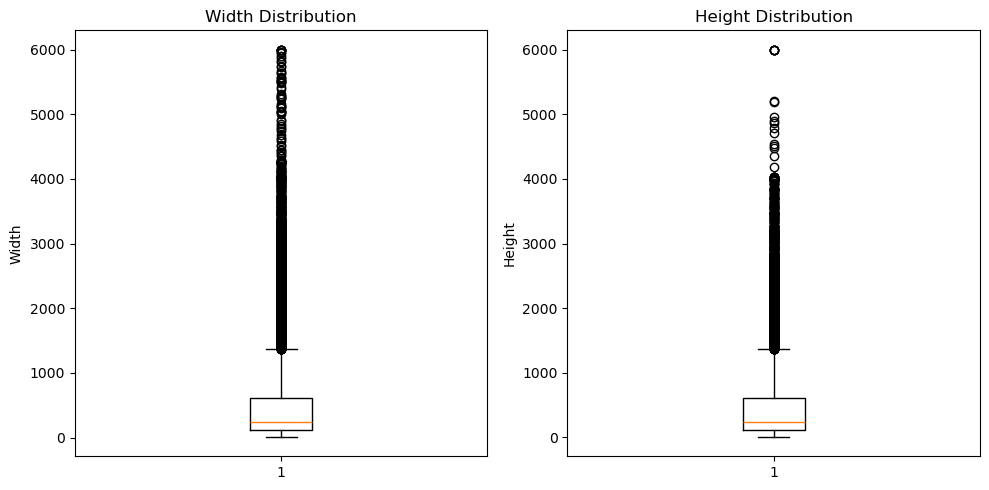

In [10]:
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg','.tif','.JPG']]

width_list = []
height_list = []

for file_path in all_files:
    with Image.open(file_path) as img:
        width, height = img.size
        width_list.append(width)
        height_list.append(height)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Create box plots for width and height
axes[0].boxplot(width_list)
axes[0].set_title('Width Distribution')
axes[0].set_ylabel('Width')
axes[1].boxplot(height_list)
axes[1].set_title('Height Distribution')
axes[1].set_ylabel('Height')

plt.tight_layout()
plt.show()


In [13]:
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg','.tif','.JPG']]

width_list = []
height_list = []

for file_path in all_files:
    with Image.open(file_path) as img:
        width, height = img.size
        width_list.append(width)
        height_list.append(height)

# Define a threshold for outliers (e.g., 3 standard deviations from the mean)
threshold = 1
mean_width = np.mean(width_list)
std_width = np.std(width_list)
mean_height = np.mean(height_list)
std_height = np.std(height_list)

# Filter out outliers based on the threshold
width_list_filtered = [width for width in width_list if abs(width - mean_width) < threshold * std_width]
height_list_filtered = [height for height in height_list if abs(height - mean_height) < threshold * std_height]

# Calculate mode and mean without outliers
mode_width_filtered = statistics.mode(width_list_filtered)
mode_height_filtered = statistics.mode(height_list_filtered)
mean_width_filtered = np.mean(width_list_filtered)
mean_height_filtered = np.mean(height_list_filtered)

print(f"Mode of Width (without outliers): {mode_width_filtered}")
print(f"Mode of Height (without outliers): {mode_height_filtered}")
print(f"Mean of Width (without outliers): {mean_width_filtered}")
print(f"Mean of Height (without outliers): {mean_height_filtered}")


Mode of Width (without outliers): 693
Mode of Height (without outliers): 693
Mean of Width (without outliers): 299.0302427205469
Mean of Height (without outliers): 288.3033448170599


In [2]:
import os
import random

def split_dataset(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
  """
  Splits a dataset of images into train, validation, and test sets in a new directory.

  Args:
      data_dir: Path to the directory containing class folders.
      output_dir: Path to the directory where split data will be saved.
      train_ratio: Ratio of data for training (default: 0.7).
      val_ratio: Ratio of data for validation (default: 0.15).
      test_ratio: Ratio of data for testing (default: 0.15).
      seed: Random seed for shuffling (default: None).

  Returns:
      None
  """
  if train_ratio + val_ratio + test_ratio != 1:
    raise ValueError("Ratios must sum to 1.")

  # Create the output directory if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)

  # Get all class folders
  class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

  # Set random seed if provided
  if seed:
    random.seed(seed)

  for class_dir in class_dirs:
    img_paths = [os.path.join(data_dir, class_dir, img) for img in os.listdir(os.path.join(data_dir, class_dir))]
    random.shuffle(img_paths)

    # Calculate split points based on ratios
    train_split = int(len(img_paths) * train_ratio)
    val_split = train_split + int(len(img_paths) * val_ratio)

    # Create train, validation, and test folders within the output directory
    train_dir = os.path.join(output_dir, "train", class_dir)
    val_dir = os.path.join(output_dir, "val", class_dir)
    test_dir = os.path.join(output_dir, "test", class_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Move images to respective folders
    for i, img_path in enumerate(img_paths):
      if i < train_split:
        new_path = os.path.join(train_dir, os.path.basename(img_path))
      elif i < val_split:
        new_path = os.path.join(val_dir, os.path.basename(img_path))
      else:
        new_path = os.path.join(test_dir, os.path.basename(img_path))
      os.replace(img_path, new_path)

# Example usage
data_dir = r"D:\Projects\Weed Detection\mohab data\to be done\tomato\New folder"  # Replace with your data directory
output_dir = r"D:\Projects\Weed Detection\mohab data\to be done\tomato\Split data"  # Replace with your desired output directory
split_dataset(data_dir, output_dir)


In [41]:
import os
import numpy as np
import cv2
from albumentations import Compose, augmentations  # Import directly for clarity (optional)


def get_augmented_image(image):
    """
    Applies random augmentations to an image.
    """
    width = int(image.shape[1] * 0.8)
    height = int(image.shape[0] * 0.8)
    transform = Compose([
        #augmentations.HorizontalFlip(p=0.5),
        #augmentations.Rotate(limit=180, p=0.5),
        augmentations.RandomBrightnessContrast(brightness_shift_limit=(0.5,1), contrast_shift_limit=0, p=1),
        #augmentations.RandomGamma(p=0.5),
        augmentations.RandomGamma(gamma_limit=(1, 3), p=1),  # Maximize exposure
        #augmentations.RandomCrop(width=width, height=height, p=0.5),
        augmentations.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=(0, 100), val_shift_limit=0, p=1)  # Added saturation augmentation
    ])
    return transform(image=image)['image']

def balance_dataset():
    print("AUGMENTING DATASET")

    train_dir = input("Enter the full path to the train directory: ")
    test_dir = input("Enter the full path to the test directory: ")
    valid_dir = input("Enter the full path to the validation directory: ")
    working_dir = input("Enter the full path where the balanced dataset will be stored: ")

    dest_dir = os.path.join(working_dir, "balanced_dataset")
    print(f"The balanced dataset will be saved to: {dest_dir}")

    if os.path.isdir(dest_dir):
        shutil.rmtree(dest_dir)  # Start with a clean empty dest_dir
    os.mkdir(dest_dir)

    test_dest_dir = os.path.join(dest_dir, "test")
    valid_dest_dir = os.path.join(dest_dir, "valid")
    shutil.copytree(test_dir, test_dest_dir)
    shutil.copytree(valid_dir, valid_dest_dir)

    train_dest_dir = os.path.join(dest_dir, "train")
    os.mkdir(train_dest_dir)

    limiter = int(input("Enter an integer value for the desired number of images per class: "))
    print(f"The dataset will be balanced to have {limiter} images in each class")

    classes = sorted(os.listdir(train_dir))  # Make a list of classes

    for klass in classes:
        classpath = os.path.join(train_dir, klass)
        dest_classpath = os.path.join(train_dest_dir, klass)
        os.mkdir(dest_classpath)  # Make a directory for this class in the balanced dataset

        flist = sorted(os.listdir(classpath))  # Get list of files in each class
        fcount = len(flist)

        # Randomly select and augment images until limiter is reached
        if fcount > limiter:    
            used_indices = set()  # Create a set to store used indices
            for i in range(limiter):
                while True:
                    index = np.random.randint(0, fcount)
                    if index not in used_indices:
                        break  # If index is not used, break the loop
                used_indices.add(index)  # Add the used index to the set

                fpath = os.path.join(classpath, flist[index])
                img = cv2.imread(fpath)
    
                augmented_img = get_augmented_image(img.copy())  # Apply augmentation to a copy
    
                dest_fpath = os.path.join(dest_classpath, f"aug_{flist[index]}")  # Unique filename for augmented image
                cv2.imwrite(dest_fpath, augmented_img)

        else:
            # for class with less than limiter files first copy across the existing files
            for f in flist:
                fpath=os.path.join(classpath,f)
                dest_fpath=os.path.join(dest_classpath,f)
                shutil.copy(fpath, dest_fpath)
            delta=limiter - fcount # this is how many augmented images we need to create for this class
            msg=f'creating {delta} augmented images for class {klass}'
            print(msg, '\r', end = '')
            aug_counter=0
            i=-1
            while aug_counter<delta:
                i +=1
                j=i % fcount # delta may be greator than the number of files in the class so use mod of count as file indexer
                fpath=os.path.join(classpath, flist[j]) # path to the image file to augment
                # give the augmented image a unique file name
                dest_fpath=os.path.join(dest_classpath,'aug-'+str(i)+'-'+ flist[j])# path of where to store the augmented image
                #print(f'fpath is {fpath}   dest_fpath is {dest_fpath}')
                img= cv2.imread(fpath)
                aug_img=get_augmented_image(img) # augment the image
                cv2.imwrite(dest_fpath, aug_img)
                aug_counter +=1

    print(f"The balanced dataset with {limiter} images per class is stored in: {dest_dir}")


In [47]:
import cv2
import numpy as np
from albumentations import Compose, RandomBrightnessContrast, RandomGamma, HueSaturationValue
from albumentations.core.transforms_interface import ImageOnlyTransform

class SelectiveSaturationIncrease(ImageOnlyTransform):
    def __init__(self, sat_shift_limit=100, always_apply=False, p=1.0):
        super(SelectiveSaturationIncrease, self).__init__(always_apply, p)
        self.sat_shift_limit = sat_shift_limit

    def apply(self, img, **params):
        # Convert to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        # Create a mask to detect white regions
        white_mask = cv2.inRange(hsv, (0, 0, 200), (180, 55, 255))  # Adjust thresholds as needed

        # Increase saturation only in non-white areas
        s = np.where(white_mask == 0, np.clip(s + self.sat_shift_limit, 0, 255), s)

        # Merge back and convert to BGR
        hsv = cv2.merge([h, s, v])
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return img
def get_augmented_image(image):
    """
    Applies random augmentations to an image.
    """
    width = int(image.shape[1] * 0.8)
    height = int(image.shape[0] * 0.8)
    transform = Compose([
        #augmentations.HorizontalFlip(p=0.5),
        #augmentations.Rotate(limit=180, p=0.5),
        #augmentations.RandomBrightnessContrast(brightness_shift_limit=(0.5,1), contrast_shift_limit=0, p=1),
        #augmentations.RandomGamma(p=0.5),
        #augmentations.RandomGamma(gamma_limit=(1, 3), p=1),  # Maximize exposure
        #augmentations.RandomCrop(width=width, height=height, p=0.5),
        SelectiveSaturationIncrease(sat_shift_limit=100, p=1)  # Added saturation augmentation
    ])
    return transform(image=image)['image']

def balance_dataset():
    print("AUGMENTING DATASET")

    train_dir = input("Enter the full path to the train directory: ")
    test_dir = input("Enter the full path to the test directory: ")
    valid_dir = input("Enter the full path to the validation directory: ")
    working_dir = input("Enter the full path where the balanced dataset will be stored: ")

    dest_dir = os.path.join(working_dir, "balanced_dataset")
    print(f"The balanced dataset will be saved to: {dest_dir}")

    if os.path.isdir(dest_dir):
        shutil.rmtree(dest_dir)  # Start with a clean empty dest_dir
    os.mkdir(dest_dir)

    test_dest_dir = os.path.join(dest_dir, "test")
    valid_dest_dir = os.path.join(dest_dir, "valid")
    shutil.copytree(test_dir, test_dest_dir)
    shutil.copytree(valid_dir, valid_dest_dir)

    train_dest_dir = os.path.join(dest_dir, "train")
    os.mkdir(train_dest_dir)

    limiter = int(input("Enter an integer value for the desired number of images per class: "))
    print(f"The dataset will be balanced to have {limiter} images in each class")

    classes = sorted(os.listdir(train_dir))  # Make a list of classes

    for klass in classes:
        classpath = os.path.join(train_dir, klass)
        dest_classpath = os.path.join(train_dest_dir, klass)
        os.mkdir(dest_classpath)  # Make a directory for this class in the balanced dataset

        flist = sorted(os.listdir(classpath))  # Get list of files in each class
        fcount = len(flist)

        # Randomly select and augment images until limiter is reached
        if fcount > limiter:    
            used_indices = set()  # Create a set to store used indices
            for i in range(limiter):
                while True:
                    index = np.random.randint(0, fcount)
                    if index not in used_indices:
                        break  # If index is not used, break the loop
                used_indices.add(index)  # Add the used index to the set

                fpath = os.path.join(classpath, flist[index])
                img = cv2.imread(fpath)
    
                augmented_img = get_augmented_image(img.copy())  # Apply augmentation to a copy
    
                dest_fpath = os.path.join(dest_classpath, f"aug_{flist[index]}")  # Unique filename for augmented image
                cv2.imwrite(dest_fpath, augmented_img)

        else:
            # for class with less than limiter files first copy across the existing files
            for f in flist:
                fpath=os.path.join(classpath,f)
                dest_fpath=os.path.join(dest_classpath,f)
                shutil.copy(fpath, dest_fpath)
            delta=limiter - fcount # this is how many augmented images we need to create for this class
            msg=f'creating {delta} augmented images for class {klass}'
            print(msg, '\r', end = '')
            aug_counter=0
            i=-1
            while aug_counter<delta:
                i +=1
                j=i % fcount # delta may be greator than the number of files in the class so use mod of count as file indexer
                fpath=os.path.join(classpath, flist[j]) # path to the image file to augment
                # give the augmented image a unique file name
                dest_fpath=os.path.join(dest_classpath,'aug-'+str(i)+'-'+ flist[j])# path of where to store the augmented image
                #print(f'fpath is {fpath}   dest_fpath is {dest_fpath}')
                img= cv2.imread(fpath)
                aug_img=get_augmented_image(img) # augment the image
                cv2.imwrite(dest_fpath, aug_img)
                aug_counter +=1

    print(f"The balanced dataset with {limiter} images per class is stored in: {dest_dir}")


In [48]:
balance_dataset()

AUGMENTING DATASET


Enter the full path to the train directory:  C:\Users\mohab\Desktop\euphorbia
Enter the full path to the test directory:  C:\Users\mohab\Desktop\euphorbia
Enter the full path to the validation directory:  C:\Users\mohab\Desktop\euphorbia
Enter the full path where the balanced dataset will be stored:  C:\Users\mohab\Desktop\pro


The balanced dataset will be saved to: C:\Users\mohab\Desktop\pro\balanced_dataset


Enter an integer value for the desired number of images per class:  140


The dataset will be balanced to have 140 images in each class
The balanced dataset with 140 images per class is stored in: C:\Users\mohab\Desktop\pro\balanced_dataset


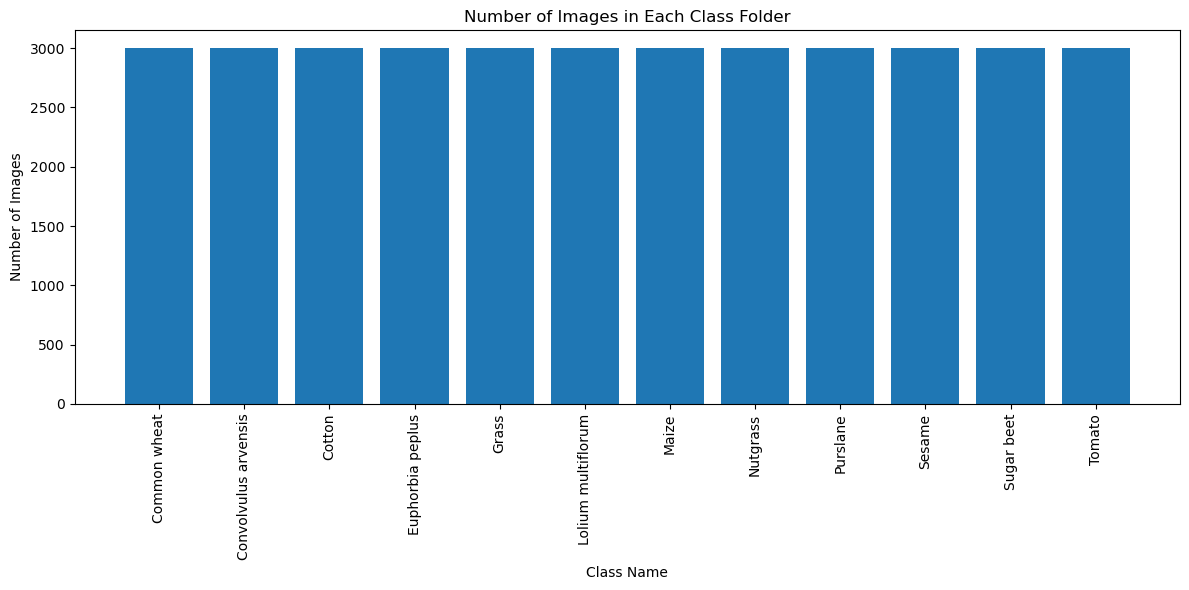

In [18]:
# Get a list of all class folders in the 'merged_folder'
folder_path = r"D:\Projects\Weed Detection\balanced_dataset\train"

class_folders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

# Initialize lists to store class names and corresponding image counts
class_names = []
image_counts = []

# Iterate through each class folder and count the images
for class_folder in class_folders:
    class_path = os.path.join(folder_path, class_folder)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_names.append(class_folder)
        image_counts.append(image_count)

# Create a bar chart to visualize the image counts for each class
plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts)
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class Folder')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the bar chart
plt.show()

In [14]:
# Define your folder path containing the images
folder_path = "D:\Projects\Weed Detection\Processed data"

# List all image files in the folder
all_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png', '.bmp','.gif', '.tiff', '.ico', '.webp','.tif','JPG']]

# Initialize a dictionary to count the number of images for each class
class_counter = defaultdict(int)

# Iterate through all files to count the number of images for each class
for file_path in all_files:
    class_name = os.path.basename(os.path.dirname(file_path))
    class_counter[class_name] += 1

# Define labels based on directory names (assuming each directory represents a class)
labels = [os.path.basename(os.path.dirname(file_path)) for file_path in all_files]

# Create a DataFrame containing file paths and labels
df = pd.DataFrame({'file_path': all_files, 'label': labels})

# Split the DataFrame into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print the number of images in each set
print("Number of training images:", len(train_df))
print("Number of validation images:", len(valid_df))
print("Number of test images:", len(test_df))


Number of training images: 18189
Number of validation images: 3898
Number of test images: 3898


In [16]:
# Define image data generator for training set
datagen = ImageDataGenerator(rescale=1./255)

# Create generator for training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),  # Specify your target size
    batch_size=32,
    class_mode='categorical'  # Adjust accordingly based on your task
)

# Create generator for validation set
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),  # Specify your target size
    batch_size=10,
    class_mode='categorical'  # Adjust accordingly based on your task
)

# Create generator for test set
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224,224),  # Specify your target size
    batch_size=10,
    class_mode='categorical'  # Adjust accordingly based on your task
)

#test_it = datagen.flow_from_directory(r"C:\Users\mohab\Desktop\New folder", batch_size=3, target_size=(620,620), class_mode="categorical")

Found 18189 validated image filenames belonging to 12 classes.
Found 3898 validated image filenames belonging to 12 classes.
Found 3898 validated image filenames belonging to 12 classes.


In [2]:
# Define image data generator for training set
datagen = ImageDataGenerator(rescale=1./255)

# Create generator for training set
train_generator = datagen.flow_from_directory(
    r"D:\Projects\Weed Detection\balanced_dataset\train",
    target_size=(224,224),  # Specify your target size
    batch_size=32,
    class_mode='categorical'  # Adjust accordingly based on your task
)

# Create generator for validation set
valid_generator = datagen.flow_from_directory(
    r"D:\Projects\Weed Detection\balanced_dataset\valid",
    target_size=(224,224),  # Specify your target size
    batch_size=10,
    class_mode='categorical'  # Adjust accordingly based on your task
)


# Create generator for test set
test_generator = datagen.flow_from_directory(
    r"D:\Projects\Weed Detection\balanced_dataset\test",
    target_size=(224,224),  # Specify your target size
    batch_size=10,
    class_mode='categorical'  # Adjust accordingly based on your task
)

test_it = datagen.flow_from_directory(r"C:\Users\mohab\Desktop\New folder", batch_size=3, target_size=(620,620), class_mode="categorical")

Found 36000 images belonging to 12 classes.
Found 3892 images belonging to 12 classes.
Found 3908 images belonging to 12 classes.
Found 35 images belonging to 6 classes.


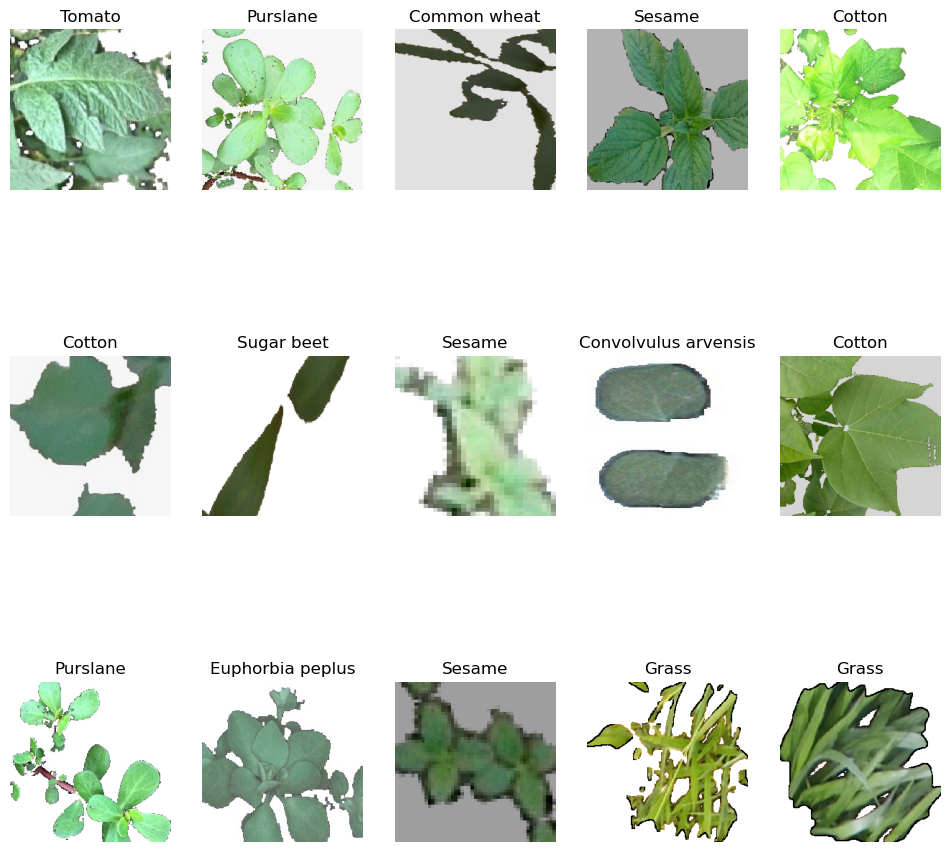

In [3]:
# Get a batch of images and labels from the train generator
batch_images, batch_labels = train_generator.next()

# Define the class labels
class_labels = train_generator.class_indices

# Display the images along with their labels
plt.figure(figsize=(12, 12))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(batch_images[i])
    label_index = np.argmax(batch_labels[i])  # Get the index of the highest probability class
    label = list(class_labels.keys())[list(class_labels.values()).index(label_index)]  # Get the corresponding class label
    plt.title(label)
    plt.axis("off")
plt.show()


In [4]:
def create_model():

    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation = "relu",input_shape=(224,224,3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation = "softmax"))
    
    model.summary()
    
    return model

In [5]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [ ]:
import graphviz
import pydot
plot_model(model, to_file='multilayer_perceptron_graph.png', show_shapes=True, show_layer_names=True)

In [6]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
print("Model Compiled!")


Model Compiled!


In [ ]:
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

callbacks_list = [earlystop , checkpoint]

training_history = model.fit(train_generator, epochs= 20, validation_data=valid_generator, callbacks=callbacks_list)
print("Model Trained!")

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/20
  35/1125 [..............................] - ETA: 10:35 - loss: 2.5351 - accuracy: 0.0884

In [6]:
filepath="weights_best.hdf5"
model.load_weights(filepath)
training_history = model.load_weights(filepath)

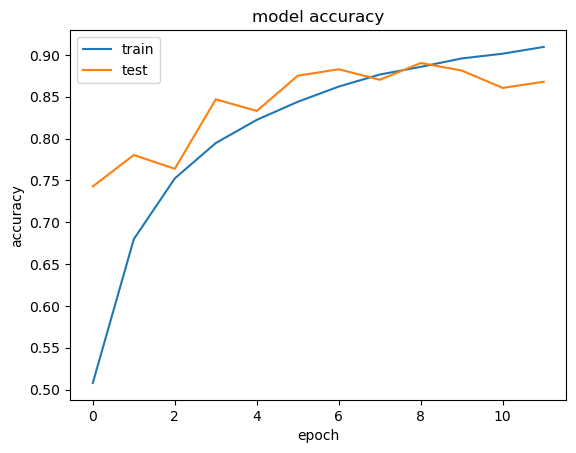

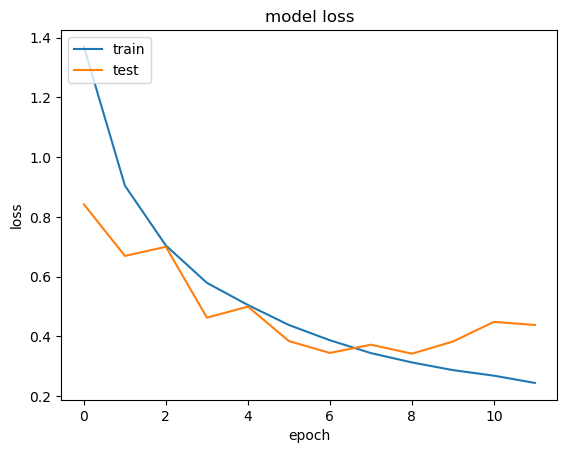

In [47]:
# summarize history for training and validation accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
scores = model.evaluate(test_generator)
print("Model Evaluated with accuracy:", scores[1]*100, "%")

391/391 [==============================] - 46s 118ms/step - loss: 0.3209 - accuracy: 0.8948
Model Evaluated with accuracy: 89.4831120967865 %


In [49]:
scores

[0.3208577036857605, 0.894831120967865]

In [50]:
# Get class indices
class_indices = test_generator.class_indices

# Get the number of classes
num_classes = len(class_indices)

# Initialize variables to store class-wise accuracies
class_accuracies = {class_index: 0 for class_index in range(num_classes)}
class_counts = {class_index: 0 for class_index in range(num_classes)}

# Iterate through the test generator and calculate accuracies
for i in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred = model.predict(x_batch)
    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_batch, axis=1)
    for true_class, predicted_class in zip(true_classes, predicted_classes):
        if true_class == predicted_class:
            class_accuracies[true_class] += 1
        class_counts[true_class] += 1

# Calculate and print accuracies for each class
for class_index in range(num_classes):
    accuracy = class_accuracies[class_index] / class_counts[class_index] * 100
    class_name = [name for name, index in class_indices.items() if index == class_index][0]
    print(f"Accuracy for class {class_name}: {accuracy:.2f}%")

1/1 [==============================] - 0s 27ms/step
Accuracy for class Common wheat: 92.50%
Accuracy for class Convolvulus arvensis: 95.53%
Accuracy for class Cotton: 90.57%
Accuracy for class Euphorbia peplus: 91.48%
Accuracy for class Grass: 98.48%
Accuracy for class Lolium multiflorum: 91.84%
Accuracy for class Maize: 75.34%
Accuracy for class Nutgrass: 73.89%
Accuracy for class Purslane: 71.14%
Accuracy for class Sesame: 94.02%
Accuracy for class Sugar beet: 87.05%
Accuracy for class Tomato: 100.00%


In [ ]:
# with highpass filter

Accuracy for class Common wheat: 27.50%
Accuracy for class Convolvulus arvensis: 86.03%
Accuracy for class Cotton: 96.18%
Accuracy for class Euphorbia peplus: 94.12%
Accuracy for class Grass: 99.24%
Accuracy for class Lolium multiflorum: 87.53%
Accuracy for class Maize: 81.28%
Accuracy for class Nutgrass: 73.57%
Accuracy for class Purslane: 71.81%
Accuracy for class Sesame: 92.74%
Accuracy for class Sugar beet: 65.47%
Accuracy for class Tomato: 44.68%

In [ ]:
#with augmentation

Accuracy for class Common wheat: 100.00%
Accuracy for class Convolvulus arvensis: 100.00%
Accuracy for class Cotton: 91.72%
Accuracy for class Euphorbia peplus: 98.56%
Accuracy for class Grass: 100.00%
Accuracy for class Lolium multiflorum: 95.24%
Accuracy for class Maize: 92.69%
Accuracy for class Nutgrass: 86.62%
Accuracy for class Purslane: 94.63%
Accuracy for class Sesame: 99.57%
Accuracy for class Sugar beet: 94.24%
Accuracy for class Tomato: 95.74%

In [ ]:
#without augmentation

Accuracy for class Common wheat: 60.61%
Accuracy for class Convolvulus arvensis: 98.30%
Accuracy for class Cotton: 98.84%
Accuracy for class Euphorbia peplus: 98.11%
Accuracy for class Grass: 100.00%
Accuracy for class Lolium multiflorum: 92.52%
Accuracy for class Maize: 81.90%
Accuracy for class Nutgrass: 86.58%
Accuracy for class Purslane: 85.11%
Accuracy for class Sesame: 80.47%
Accuracy for class Sugar beet: 93.01%
Accuracy for class Tomato: 53.19%

In [33]:
print("Class indices:", train_generator.class_indices)


Class indices: {'Common wheat': 0, 'Convolvulus arvensis': 1, 'Cotton': 2, 'Euphorbia peplus': 3, 'Grass': 4, 'Lolium multiflorum': 5, 'Maize': 6, 'Nutgrass': 7, 'Purslane': 8, 'Sesame': 9, 'Sugar beet': 10, 'Tomato': 11}


1/1 [==============================] - 0s 18ms/step
Image: canny_374211639_2349567001911356_2853170556047787725_n.jpg
Predicted class: Common wheat


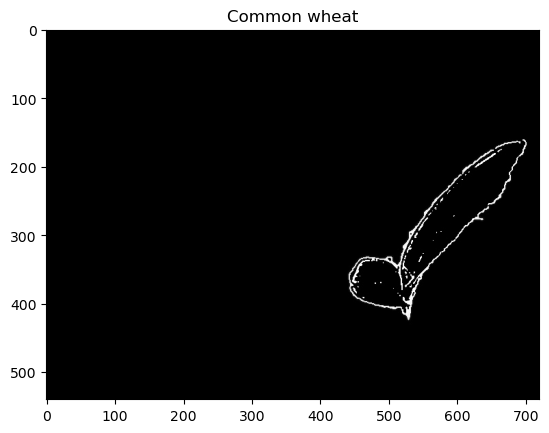

1/1 [==============================] - 0s 17ms/step
Image: canny_images.jpg
Predicted class: Lolium multiflorum


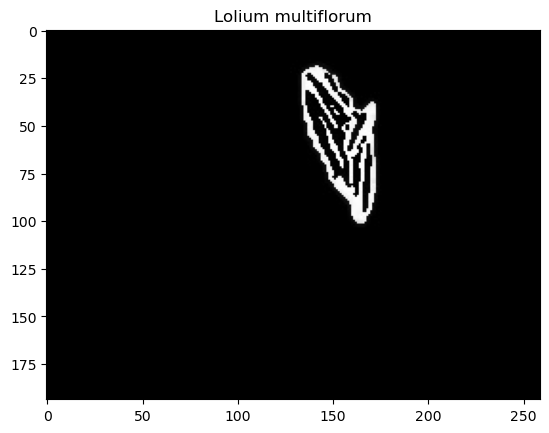

1/1 [==============================] - 0s 19ms/step
Image: canny_imags.jpg
Predicted class: Lolium multiflorum


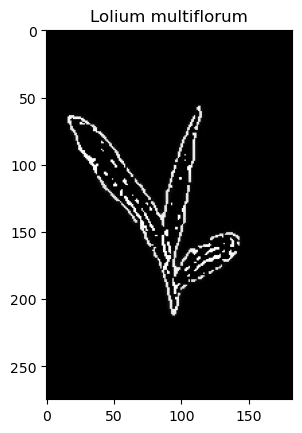

1/1 [==============================] - 0s 17ms/step
Image: canny_WhatsApp Image 2024-04-12 at 15.25.11_9799ec7f.jpg
Predicted class: Lolium multiflorum


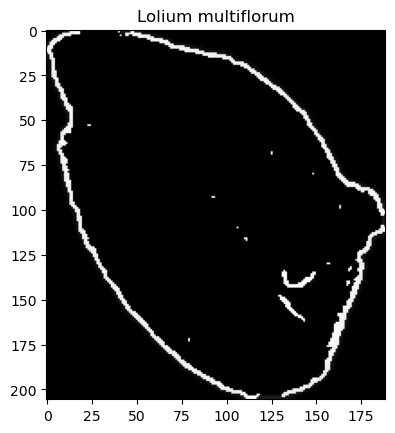

In [56]:
# Define your class indices
class_indices = {
    'Common wheat': 0,
    'Convolvulus arvensis': 1,
    'Cotton': 2,
    'Euphorbia peplus': 3,
    'Grass': 4,
    'Lolium multiflorum': 5,
    'Maize': 6,
    'Nutgrass': 7,
    'Purslane': 8,
    'Sesame': 9,
    'Sugar beet': 10,
    'tomato': 11
}

# Function to preprocess image
def preprocess_image(image):
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32') / 255  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict class of an image
def predict_image(image):
    image = preprocess_image(image)
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = [k for k, v in class_indices.items() if v == predicted_class_index][0]
    return predicted_class_name

# Function to process images in a directory and its subdirectories
def process_images_in_directory(directory):
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
        image_path = os.path.join(root, file)
        image = cv2.imread(image_path)
        predicted_class_name = predict_image(image)
        print("Image:", file)
        print("Predicted class:", predicted_class_name)

        # Display image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
        plt.title(predicted_class_name)  # Add title with predicted class
        plt.show()  # Display the image
# Replace 'your_directory_path' with the path to your directory containing images
process_images_in_directory(r"C:\Users\mohab\Desktop\New folder pr\Maize")


In [75]:
# Load the image
image_path = r"C:\Users\mohab\Desktop\New folder\tomato\WhatsApp Image 2024-04-12 at 15.25.13_295d1696.jpg" # Replace with the path to your image
image = cv2.imread(image_path)

# Resize and preprocess the image
# Assuming your model requires images of size 620x620 (as specified in your generators)
image = cv2.resize(image, (620, 620))
image = image.astype('float32') / 255  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(image)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Define your class indices
class_indices = {
    'Common wheat': 0,
    'Convolvulus arvensis': 1,
    'Euphorbia peplus': 2,
    'Lolium multiflorum': 3,
    'Maize': 4,
    'Molochai_lozniy': 5,
    'Nutgrass': 6,
    'Purslane': 7,
    'SpottedSpurge': 8,
    'SpurredAnoda': 9,
    'Sugar beet': 10,
    'cotton': 11,
    'grass': 12,
    'sesame': 13,
    'tomato': 14
}

# Map the predicted class index to class name
predicted_class_name = [k for k, v in class_indices.items() if v == predicted_class_index][0]

print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 98ms/step


IndexError: list index out of range

In [35]:
# Load the image
image_path = r"C:\Users\mohab\Desktop\New folder\cotton\WhatsApp Image 2024-04-12 at 15.25.10_c3ce9141.jpg"# Replace with the path to your image
image = cv2.imread(image_path)

# Resize and preprocess the image
# Assuming your model requires images of size 620x620 (as specified in your generators)
image = cv2.resize(image, (224,224))
image = image.astype('float32') / 255  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(image)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Define your class indices
class_indices = {
    'Common wheat': 0,
    'Convolvulus arvensis': 1,
    'Euphorbia peplus': 2,
    'Lolium multiflorum': 3,
    'Maize': 4,
    'Nutgrass': 5,
    'Purslane': 6,
    'Sugar beet': 7,
    'cotton': 8,
    'sesame': 9,
    'tomato': 10
}

# Map the predicted class index to class name
predicted_class_name = [k for k, v in class_indices.items() if v == predicted_class_index][0]

print("Predicted class:", predicted_class_name)

1/1 [==============================] - 0s 18ms/step
Predicted class: sesame


In [9]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detection_frame(img, x, y, w, h, prediction):
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)

    for (x,y,w,h) in faces:
        cropped_image = img[y:y+h, x:x+w]
        img_arr = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        img_arr = cv2.resize(img_arr, (256,256), interpolation = cv2.INTER_AREA)
        img_arr = np.expand_dims(img_arr, 0)
        prediction = model.predict(img_arr)
    return img, prediction, x, y, h, w

In [17]:
x = -100
y = -100
w = 0 
h = 0
prediction = 0

# define a video capture object
vid = cv2.VideoCapture(0)
itera = 0
while(True):

    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    #iterate the detection function once every 5 frames
    itera += 1
    if itera % 5 == 0 or itera <=5 :

        #Function implementation
        frame, prediction, x, y, h, w = face_detection_frame(frame, x, y, w, h, prediction)

    #During the 5 frames we produce the same output of the last function implementation
    if prediction > 0.5 : #If without mask
        cv2.putText(img=frame, text='without mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

    else :                #If with mask
        cv2.putText(img=frame, text='with mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

    # Display the resulting frame
    cv2.imshow('frame', frame)

    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()